In [ ]:
import pandas as pd

# ucitavanje već pripremljenog orders_merged csv-a
orders = pd.read_csv(r"C:\Users\bojana.boskovic\Downloads\orders_merged_with_status.csv", parse_dates=['Order Date', 'Ship Date'])

# proovera i zamena null vrednosti medianom
null_counts = orders.isnull().sum()
total_rows_with_nulls = orders[orders.isnull().any(axis=1)].shape[0]
print(f"Broj redova sa null vrednostima: {total_rows_with_nulls}")

# popunjavanje num kolona medianom
numeric_cols = orders.select_dtypes(include='number').columns
orders[numeric_cols] = orders[numeric_cols].fillna(orders[numeric_cols].median())




Broj redova sa null vrednostima: 16


In [22]:
# dodavanje kolone sa brojem dana izmedju order i ship date
orders['Days Between'] = (orders['Ship Date'] - orders['Order Date']).dt.days

print(orders[['Row ID', 'Order Date', 'Ship Date', 'Days Between']].head())

# postal code (kao 5-cifren string, sa nulama ispred)
orders['Postal Code'] = orders['Postal Code'].astype(str).str.zfill(5)
print(orders[['Postal Code']].head())


   Row ID Order Date  Ship Date  Days Between
0   24844 2015-05-12 2015-05-14             2
1   24846 2015-05-12 2015-05-13             1
2   24847 2015-05-12 2015-05-13             1
3   24848 2015-05-12 2015-05-13             1
4   22890 2015-05-09 2015-05-11             2
  Postal Code
0       55372
1       55372
2       55372
3       55372
4       78664



Top 3 korelacije:
 Unit Price     Sales                  0.443562
Profit         Sales                  0.364403
Shipping Cost  Product Base Margin    0.358983
dtype: float64

Najslabije 3 korelacije:
 Unit Price  Profit                 -0.182062
            Quantity ordered new   -0.072530
Discount    Profit                 -0.061820
dtype: float64


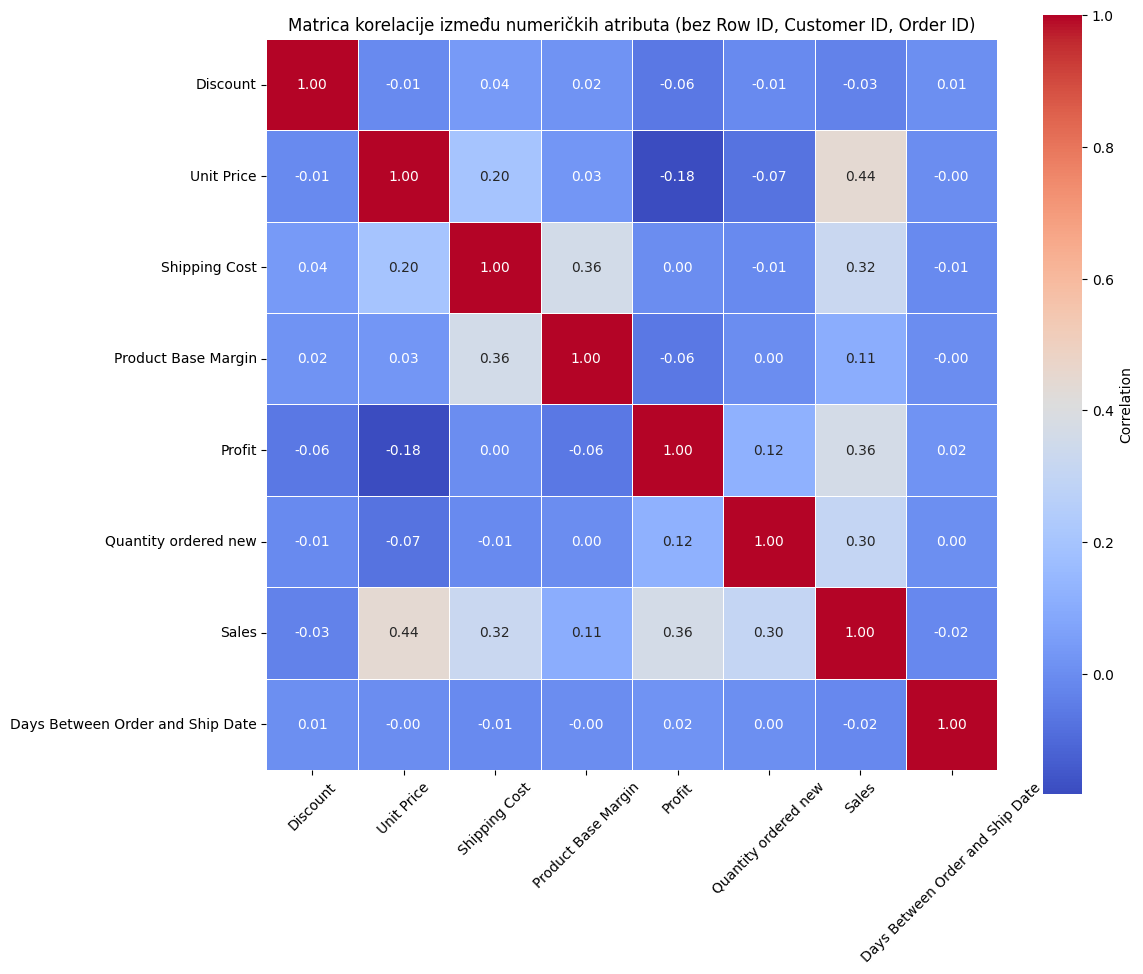

In [ ]:
# korelacija (isključujemo id kolone)
columns_to_exclude = ['Row ID', 'Customer ID', 'Order ID']
corr_df = orders.drop(columns=columns_to_exclude).corr(numeric_only=True)

#  top 3 i bottom 3 parovi
corr_unstacked = corr_df.where(~(corr_df == 1)).unstack().dropna()
corr_unstacked = corr_unstacked[~corr_unstacked.duplicated()]

top_3 = corr_unstacked.sort_values(ascending=False).head(3)
bottom_3 = corr_unstacked.sort_values().head(3)

print("\nTop 3 korelacije:\n", top_3)
print("\nNajslabije 3 korelacije:\n", bottom_3)

# export u CSV
corr_summary = pd.concat([top_3, bottom_3]).reset_index()
corr_summary.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_summary.to_csv('correlation_summary.csv', index=False)

import seaborn as sns
import matplotlib.pyplot as plt

# vizuelni prikaz matrice korelacije
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Matrica korelacije između numeričkih atributa (bez Row ID, Customer ID, Order ID)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# cuvanje kao png
plt.savefig('correlation_matrix.png')

# graf
plt.show()


In [5]:
# 6. Top 10 kupaca po Sales
top_customers = (
    orders.groupby(['Customer ID', 'Customer Name'])['Sales']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)
top_customers.to_csv("Top_10_customers.csv", index=False)



In [6]:
# 7. Pivot tabele — definicija funkcije
def create_and_export_pivot(index_col, file_name):
    pivot = orders.groupby(index_col).agg({
        'Discount': 'mean',
        'Shipping Cost': 'mean',
        'Days Between Order and Ship Date': 'mean',
        'Profit': 'sum',
        'Sales': 'sum'
    }).round(2).reset_index()

    # Preimenovanje kolona
    pivot.columns = [index_col,
                     'Avg Discount',
                     'Avg Shipping Cost',
                     'Avg Days Between Order and Ship Date',
                     'Total Profit',
                     'Total Sales']
    
    pivot.to_csv(file_name, index=False)

# Kreiranje svih pivot tabela
create_and_export_pivot('Order Priority', 'pivot_order_priority.csv')
create_and_export_pivot('Customer Segment', 'pivot_customer_segment.csv')
create_and_export_pivot('Product Category', 'pivot_product_category.csv')
create_and_export_pivot('Product Sub-Category', 'pivot_product_subcategory.csv')
create_and_export_pivot('State or Province', 'pivot_state_or_province.csv')